In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5745, done.
remote: Counting objects: 100% (934/934), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 5745 (delta 803), reused 806 (delta 693), pack-reused 4811
Receiving objects: 100% (5745/5745), 2.93 GiB | 52.13 MiB/s, done.
Resolving deltas: 100% (4629/4629), done.
Updating files: 100% (487/487), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 23.6 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 46.8 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker
from lightgbm import LGBMRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgbo

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [12]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [13]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [20]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [21]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [22]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [23]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1284.68 column/sec. Elapsed time 17.39 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1106.35 column/sec. Elapsed time 11.77 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3150.95 column/sec. Elapsed time 7.09 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity col

In [24]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [25]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_20/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [26]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [27]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [28]:
training_dataframe.Label.sum()

15808

In [29]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [30]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/2167912425.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_20/2167912425.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.092288,0.0,0.017127,5.003698,23.036989,12,1.769231,4.361839,3.374200,11.722106
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,0.086162,0.0,0.018270,3.696277,12.423644,13,0.538462,0.518875,-0.175204,-2.363636
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,0.073953,0.0,0.018064,2.531372,5.318754,13,2.846154,1.281025,1.739773,2.423997
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,0.067306,0.0,0.019153,1.729575,1.577202,6,17.153846,17.808454,1.413252,1.194462
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,0.082681,0.0,0.015344,5.003704,23.037041,6,70.076923,131.389663,2.596045,6.857221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,0.041414,0.0,0.006039,6.559126,41.022152,2,59.384615,42.940925,0.471016,-0.715981
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.059903,0.0,0.008736,6.559142,41.022297,3,55.615385,49.279033,1.114899,1.401887
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,0.036249,0.0,0.009074,2.990309,7.077977,1,264.538462,452.349536,2.878478,9.036872
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,0.039994,0.0,0.005832,6.559140,41.022385,0,1282.230769,2981.329210,2.178553,3.224977


In [31]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,23.036989,12,1.769231,4.361839,3.374200,11.722106,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,12.423644,13,0.538462,0.518875,-0.175204,-2.363636,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,5.318754,13,2.846154,1.281025,1.739773,2.423997,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,1.577202,6,17.153846,17.808454,1.413252,1.194462,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,23.037041,6,70.076923,131.389663,2.596045,6.857221,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,41.022152,2,59.384615,42.940925,0.471016,-0.715981,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,41.022297,3,55.615385,49.279033,1.114899,1.401887,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,7.077977,1,264.538462,452.349536,2.878478,9.036872,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,41.022385,0,1282.230769,2981.329210,2.178553,3.224977,0.047915,0.055156,53.265190,112.935230


In [32]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,43.0,0.0,0.047095,46.0,0.0,0.063939,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,41.0,0.0,0.031756,125.0,0.0,0.061394,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,106.0,0.0,0.059093,621.0,0.0,0.086976,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,48.0,0.0,0.219686,48.0,0.0,0.049547,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,53.0,0.0,0.026436,2196.0,0.0,0.096624,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,30.0,0.0,0.353050,8.0,1.0,0.167004,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [33]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'

XGB_model = XGBRanker(**xgboost_params)

In [34]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lightgbm.json', 'r') as params_file:
    lgbm_params = json.load(params_file)
lgbm_params['boosting_type'] = 'gbdt'

LGBM_model = LGBMRanker(**lgbm_params)

In [35]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [36]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

LGBM_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(colsample_bytree=0.2179835350475061,
           learning_rate=0.00018270369539558943, max_depth=15,
           min_child_samples=37, min_child_weight=0.02524819534352372,
           min_split_gain=4.797127375425112e-06, n_estimators=796,
           num_leaves=510, objective='lambdarank',
           reg_alpha=2.518431276561293e-05, reg_lambda=0.003486018999199874,
           subsample=0.8368752485377281, subsample_freq=18)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

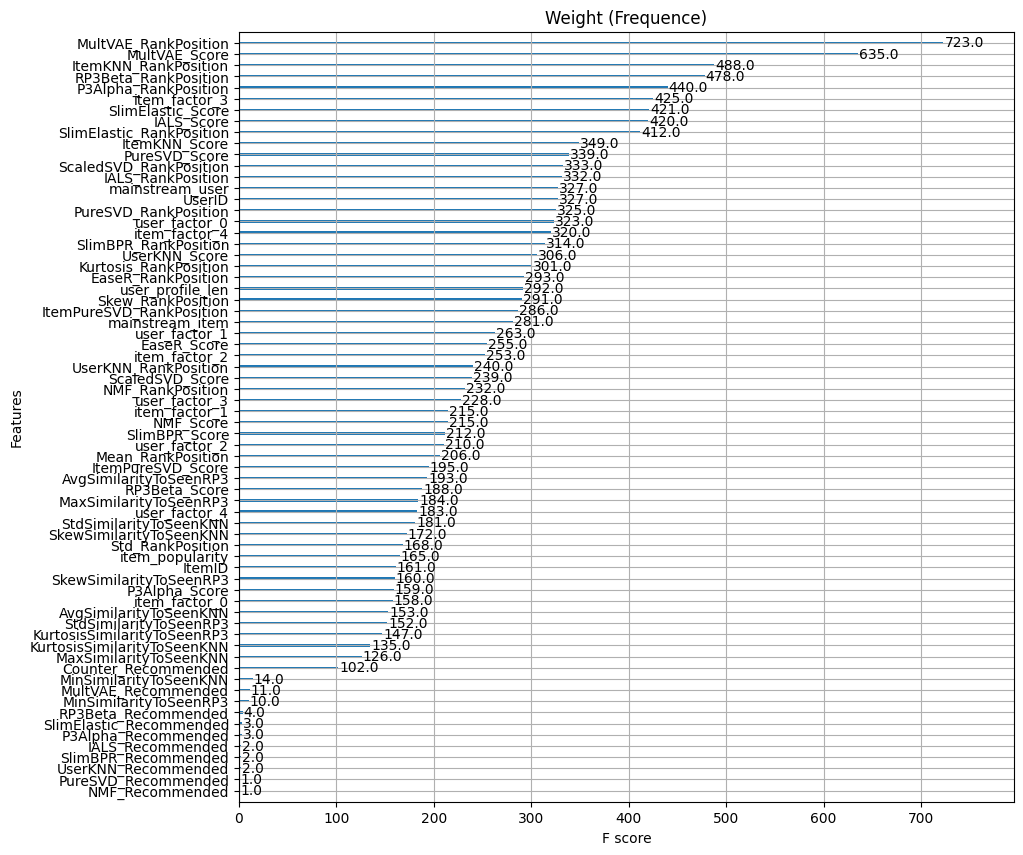

In [37]:
from xgboost import plot_importance as xgboost_plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
xgboost_plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

<Axes: title={'center': 'Gain'}, xlabel='Feature importance', ylabel='Features'>

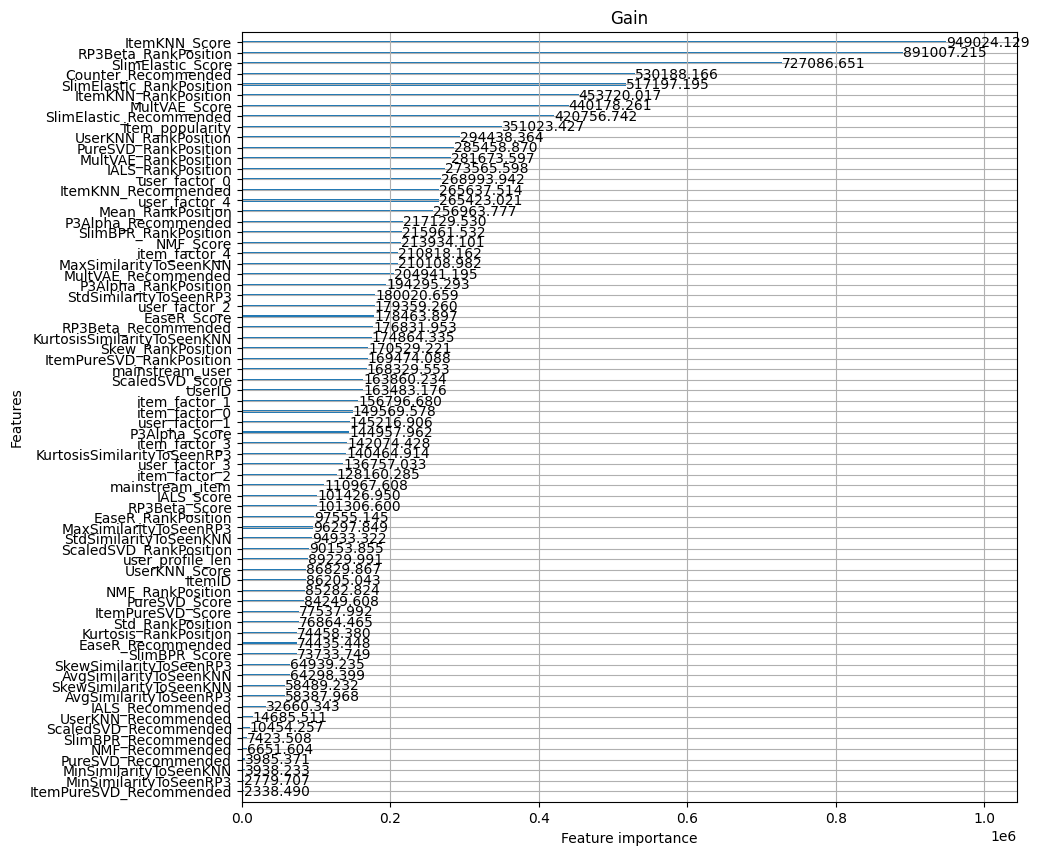

In [38]:
from lightgbm import plot_importance as lgbm_plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lgbm_plot_importance(LGBM_model, importance_type='gain', title='Gain', ax=ax)

In [39]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1230.52 column/sec. Elapsed time 18.16 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1026.81 column/sec. Elapsed time 12.68 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3050.77 column/sec. Elapsed time 7.33 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity col

In [40]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [41]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.018748,5.003693,23.036957,11,1.923077,4.071477,2.175531,3.437792,0.406406,0.032075
1,0,100,0.830547,1.0,1.0,0.296112,1.0,1.0,0.744487,1.0,...,0.018819,3.772862,13.105057,13,0.692308,0.480384,-0.946212,-1.339394,0.237011,0.032075
2,0,505,0.471617,3.0,1.0,0.135064,4.0,1.0,0.288312,3.0,...,0.016424,2.626812,5.960841,13,4.307692,2.287087,1.133427,0.077800,0.074733,0.032075
3,0,51,0.213902,19.0,0.0,0.042878,115.0,0.0,0.111361,14.0,...,0.000000,NaN,NaN,6,31.000000,55.744955,2.407078,5.300452,0.202135,0.032075
4,0,402,0.598366,2.0,1.0,0.122285,5.0,1.0,0.283639,4.0,...,0.013440,3.071784,8.519635,10,6.923077,7.631749,2.361927,5.964702,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,59.0,0.0,0.059399,687.0,0.0,0.057316,77.0,...,0.000000,NaN,NaN,2,117.769231,192.693260,2.601724,6.883997,0.113879,0.056604
651196,13023,852,0.056650,89.0,0.0,0.338165,19.0,0.0,0.000000,8068.0,...,0.000000,NaN,NaN,0,1289.846154,3017.322650,2.178113,3.221687,0.054093,0.056604
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.005985,6.559123,41.022182,0,754.153846,2282.903445,3.561982,12.762869,0.054804,0.056604
651198,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,219.307692,401.943069,2.519103,6.030330,0.004982,0.056604


In [42]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,7509.0,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,21.0,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,7480.0,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,8.0,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,16.0,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [43]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [44]:
class EnsembleGBMRerankerRecommender:
    def __init__(self, URM_train, gb_models, df):
        self.URM_train = URM_train
        self.df = df
        self.gb_models = gb_models
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = np.zeros(len(df_slice))
            for model in self.gb_models:
                preds += model.predict(df_slice)
            preds /= len(self.gb_models)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [45]:
recommender = EnsembleGBMRerankerRecommender(URM_train_complete, [XGB_model, LGBM_model], validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 3.63 min. Users per second: 48


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.100966,0.175768,0.148811,0.052323,0.089371,0.28729,0.160277,0.120306,0.544568,0.383158,...,0.802826,0.437193,0.802826,0.04635,9.862445,0.996479,0.133739,0.759764,2.152343,0.290367


In [46]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1311.98 column/sec. Elapsed time 17.03 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1061.79 column/sec. Elapsed time 12.27 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3100.17 column/sec. Elapsed time 7.21 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity col

In [47]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [48]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_20/81499794.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,...,0.069509,0.012281,0.084055,-0.077141,0.016947,0.005573,0.000275,0.007796,-0.010629,-0.001532
27,0,86,False,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,...,0.052684,0.052129,0.027570,-0.095369,-0.011876,0.005573,0.000275,0.007796,-0.010629,-0.001532
28,0,1082,False,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,...,0.009403,-0.015195,0.006102,0.006966,-0.003842,0.005573,0.000275,0.007796,-0.010629,-0.001532
29,0,636,False,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,...,0.009143,0.000775,0.011285,-0.008497,0.002122,0.005573,0.000275,0.007796,-0.010629,-0.001532
30,0,1337,False,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,...,0.008009,-0.013009,0.019274,0.015060,0.043693,0.005573,0.000275,0.007796,-0.010629,-0.001532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,...,0.012542,-0.028591,0.021117,0.003768,0.045816,0.009693,-0.007923,-0.000423,0.004501,0.023067
651194,13023,14,False,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,...,0.096477,0.024108,0.105287,-0.131175,0.008536,0.009693,-0.007923,-0.000423,0.004501,0.023067
651153,13023,732,False,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,...,0.016157,-0.035323,0.015266,0.016977,0.054954,0.009693,-0.007923,-0.000423,0.004501,0.023067
651154,13023,324,False,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,...,0.024626,-0.042587,0.041389,0.035772,0.073502,0.009693,-0.007923,-0.000423,0.004501,0.023067


In [49]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [50]:
XGB_model = XGBRanker(**xgboost_params)
LGBM_model = LGBMRanker(**lgbm_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

LGBM_model.fit(
    X_train,
    y_train,
    group=groups
)

LGBMRanker(colsample_bytree=0.2179835350475061,
           learning_rate=0.00018270369539558943, max_depth=15,
           min_child_samples=37, min_child_weight=0.02524819534352372,
           min_split_gain=4.797127375425112e-06, n_estimators=796,
           num_leaves=510, objective='lambdarank',
           reg_alpha=2.518431276561293e-05, reg_lambda=0.003486018999199874,
           subsample=0.8368752485377281, subsample_freq=18)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

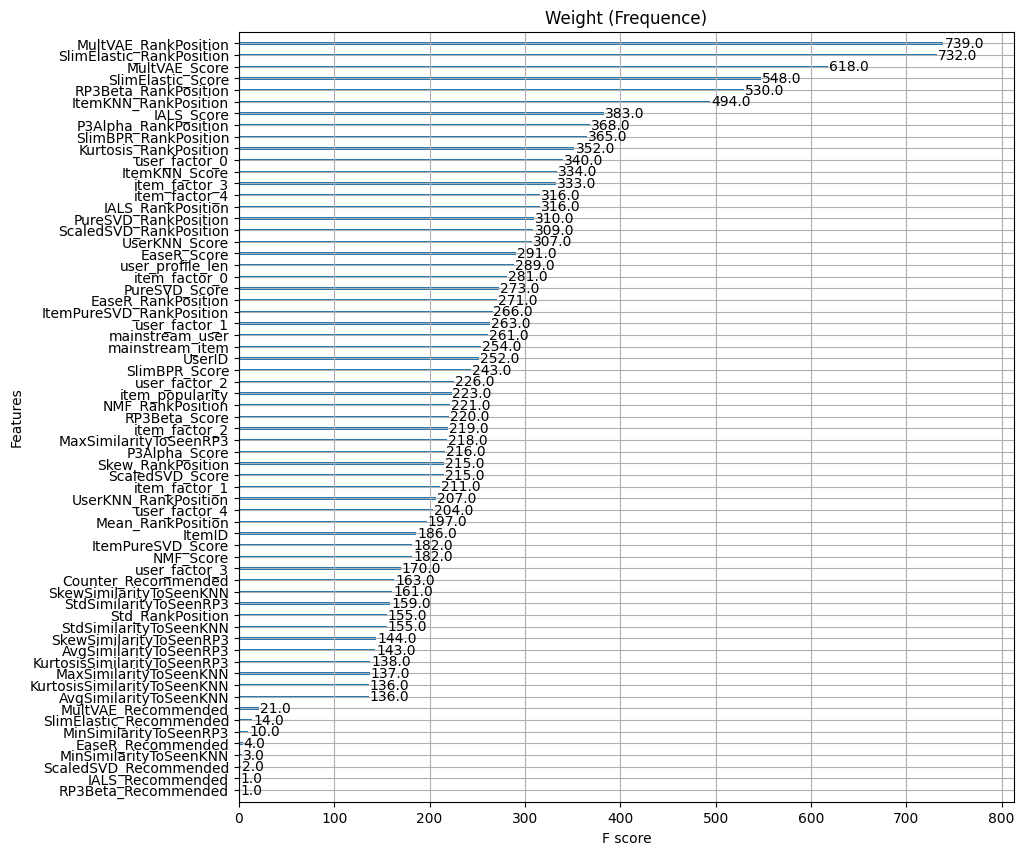

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
xgboost_plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

<Axes: title={'center': 'Gain'}, xlabel='Feature importance', ylabel='Features'>

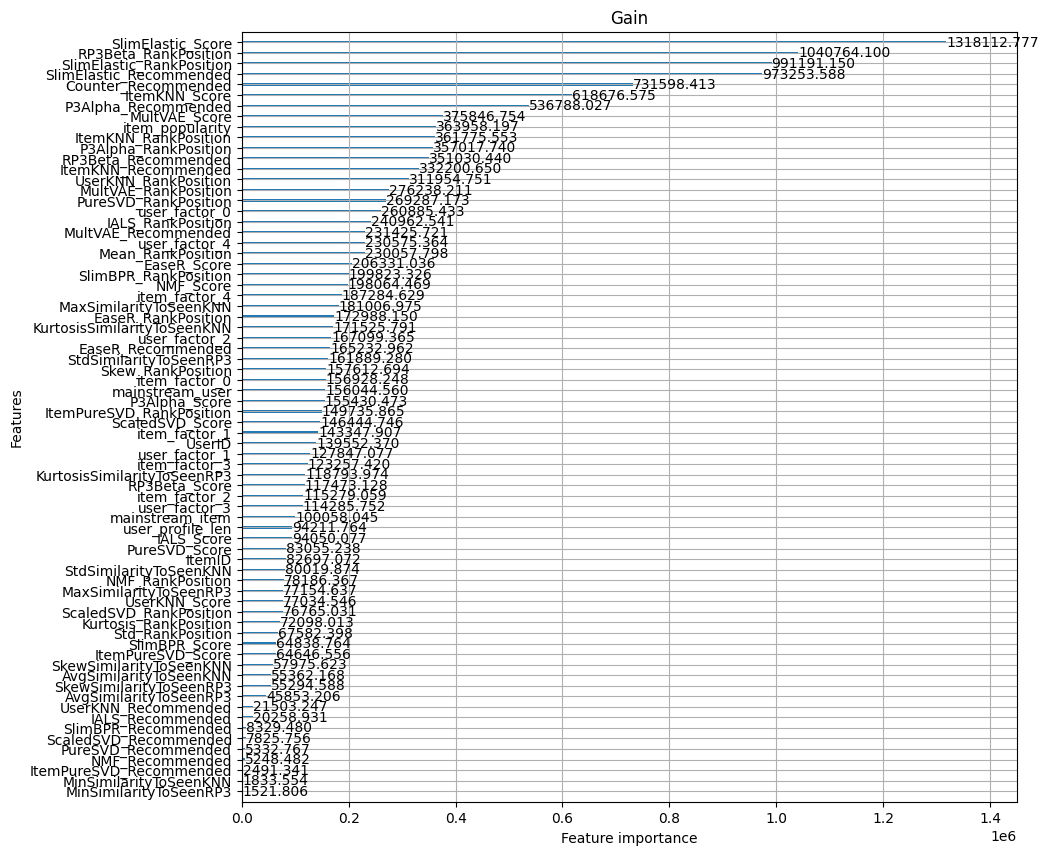

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lgbm_plot_importance(LGBM_model, importance_type='gain', title='Gain', ax=ax)

In [53]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1206.37 column/sec. Elapsed time 18.52 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 953.64 column/sec. Elapsed time 13.66 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2822.59 column/sec. Elapsed time 7.92 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity colu

In [54]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [55]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_20/1139215485.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.0,1.0,0.474078,1.0,1.0,0.786014,1.0,...,0.045669,0.010434,0.052234,-0.058738,0.022097,0.005573,0.000275,0.007796,-0.010629,-0.001532
27,0,111,0.082615,73.0,0.0,0.121925,11.0,0.0,0.000000,7415.0,...,0.040914,-0.012060,0.014534,-0.047849,-0.023057,0.005573,0.000275,0.007796,-0.010629,-0.001532
28,0,215,0.180754,23.0,0.0,0.012160,1619.0,0.0,0.085517,21.0,...,0.035591,0.015863,-0.019046,0.043921,0.006126,0.005573,0.000275,0.007796,-0.010629,-0.001532
29,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015195,0.006102,0.006966,-0.003842,0.005573,0.000275,0.007796,-0.010629,-0.001532
30,0,1337,0.235539,18.0,0.0,0.008058,3644.0,0.0,0.064524,39.0,...,0.008009,-0.013009,0.019274,0.015060,0.043693,0.005573,0.000275,0.007796,-0.010629,-0.001532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,58.0,0.0,0.442709,21.0,0.0,0.073992,64.0,...,0.006622,-0.017001,0.013132,0.007496,0.036450,0.009693,-0.007923,-0.000423,0.004501,0.023067
651150,13023,732,0.576149,5.0,1.0,0.711712,0.0,1.0,0.773915,2.0,...,0.016157,-0.035323,0.015266,0.016977,0.054954,0.009693,-0.007923,-0.000423,0.004501,0.023067
651180,13023,685,0.047530,102.0,0.0,0.459579,17.0,0.0,0.000000,7209.0,...,0.010855,-0.026115,0.011748,0.007979,0.029310,0.009693,-0.007923,-0.000423,0.004501,0.023067
651153,13023,2119,0.660220,2.0,1.0,0.547857,5.0,1.0,0.593510,6.0,...,0.004605,-0.013690,0.006539,0.004984,0.021545,0.009693,-0.007923,-0.000423,0.004501,0.023067


In [56]:
recommender = EnsembleGBMRerankerRecommender(URM_all, [XGB_model, LGBM_model], prediction_dataframe)

In [57]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 123 506 403 515 1546 694 977 3311
1,2,1095 1522 12 47 11 2 196 102 359 656
2,3,59 857 259 4252 536 648 584 956 9 414
3,4,249 28 50 7 171 5 139 314 146 2
4,5,1570 5138 77 131 471 170 1511 1220 95 215
